In [6]:
%matplotlib inline
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_VISIBLE_DEVICES=1


In [7]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import math

2025-02-27 19:20:08.401747: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740684008.411540   62780 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740684008.414523   62780 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-27 19:20:08.424931: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Acoustic Array Geometry

In [8]:
geometry = pd.read_csv('../AA_geometry.tsv', header=None, sep='\t')
AA_Geometry = geometry.to_numpy()

# Extract Data

In [9]:
class DataExtract:
    _path_dir = None
    _n_channels = None
    _files_tau = None
    _files_dat = None
    _time_delays = None
    _angles = None
    def __init__(self, path_dir, n_channels):
        self._path_dir = path_dir
        self._n_channels = n_channels
        self._extract_angles()
        self._extract_delays()
        self._max_norm()
        self._fixed_ref_channel()

    # This function uses for sorting files
    def _key(self, file):
        # Sort by character at 26th place (digit)
        return(file[26])
        
    def _extract_angles(self):
        # Source signal information files
        self._files_dat = [i for i in os.listdir(self._path_dir) if os.path.isfile(os.path.join(self._path_dir,i)) and \
                 '.dat' in i]
        self._files_dat = sorted(self._files_dat, key = self._key)   
        print(self._files_dat)
        
        # Extract signal information
        dats = []
        for file in self._files_dat:
            with open(self._path_dir+file, 'r') as f:
                lines = f.readlines()
                for i,l in enumerate(lines):
                    if (i>0):
                        dat = [float(i) for i in l.split()]
                        dats.append(dat)
        self._angles = np.array(dats, dtype=np.float32)[:,2]
        self._angles = np.reshape(self._angles, [self._angles.shape[0], 1])

    def _extract_delays(self):
        # Time delay files
        self._files_tau = [i for i in os.listdir(self._path_dir) if os.path.isfile(os.path.join(self._path_dir,i)) and \
                           'tau.bin' in i]
        self._files_tau = sorted(self._files_tau, key = self._key)   
        print(self._files_tau)
        
        # Extract Time delay
        taus = []
        for file in self._files_tau:
            with open(self._path_dir+file, 'rb') as f:
                delay = f.read()
                delay = np.frombuffer(delay, dtype = np.float32)
                delay = np.resize(delay, (int(len(delay)/self._n_channels), self._n_channels))
                taus.append(delay)
        taus_np = np.array(taus, dtype=np.float32)
        self._time_delays = taus_np.reshape(taus_np.shape[0]*taus_np.shape[1], taus_np.shape[2])
        
    def _max_norm(self):
        abs_max = np.max(np.abs(self._time_delays), axis = (0,1))
        self._time_delays /= abs_max

    def _fixed_ref_channel(self):
        self._time_delays -= self._time_delays[:,[0]]
        
    def plot(self):
        # Time delay vs angle at different channel
        fig = plt.figure(figsize = (20,20))
        ax = plt.axes()
        for i in range(self._n_channels):
            ax.scatter(self._angles, self._time_delays[:,i], label="ch{}".format(i))
        plt.title("Time Delay vs. DOA for Each Channel")
        ax.set_xlabel('DOA (degree)', fontweight ='bold') 
        ax.set_ylabel('Time Delay (ms)', fontweight ='bold') 
        ax.legend()

    def get_delays(self, channels=[]):
        if channels:
            # return specific channels
            return(self._time_delays[:,channels])
        return(self._time_delays)
        
    def get_angles(self):
        return(self._angles) 

In [10]:
class DataSetPacker:
    def __init__(self, inputs, labels, channels=[]):
        self._inputs = inputs
        self._labels = labels
        self._channels = channels
        self._dataset = None
        self._inputs_subset = None
        
        self._dataset_train = None
        self._dataset_test = None
        self._dataset_val = None

        self._selected_channels()
        self._pack_data()
    def _selected_channels(self):
        # get the selected channels
        if self._channels:
            self._inputs_subset = self._inputs[:,self._channels]
        else:
            self._inputs_subset = self._inputs
    def _pack_data(self):
        # pack data into tensorflow dataset
        self._dataset = tf.data.Dataset.from_tensor_slices((self._inputs_subset, self._labels))
        
    def _shuffle_dataset(self, buffer_size):
        # shuffle dataset
        self._dataset = self._dataset.shuffle(buffer_size = buffer_size)
        
    def split(self, ratio=[0.7,0.15,0.15], shuffle=True, shuffle_buffer_size = 5):
        # return splits
        dataset_size = len(self._inputs)
        if shuffle:
            self._shuffle_dataset(shuffle_buffer_size)
        if len(ration) == 3:
            train_size = int(ratio[0]*dataset_size)
            val_size = int(ratio[1]*dataset_size)
            test_size = int(ratio[2]*dataset_size)
            self._dataset_train = self._dataset.take(train_size)
            self._dataset_test = self._dataset.skip(train_size)
            self._dataset_val = self._dataset.skip(test_size)
            self._dataset_test = self._dataset.take(test_size)
            return self._dataset_train, self._dataset_val, self._dataset_test
        else:
            train_size = int(ratio[0]*dataset_size)
            test_size = int(ratio[1]*dataset_size)
            self._dataset_train = self._dataset.take(train_size)
            self._dataset_test = self._dataset.skip(train_size)
            return self._dataset_train, self._dataset_test
    def plot(self):
        # Time delay vs angle at different channel
        fig = plt.figure(figsize = (20,20))
        ax = plt.axes()
        for i in range(len(self._channels)):
            ax.scatter(self._labels, self._inputs_subset[:,i], label="ch{}".format(self._channels[i]))
        plt.title("Time Delay vs. DOA for Each Channel")
        ax.set_xlabel('DOA (degree)', fontweight ='bold') 
        ax.set_ylabel('Time Delay (ms)', fontweight ='bold') 
        ax.legend()

In [65]:
class Visualizer:
    def __init__(self, AA_geometry):
        self._AA_geometry_cart = AA_geometry
        self._AA_geometry_polar = np.empty(AA_geometry[:,:2].shape)
        self._AA_geometry_sphe = np.empty(AA_geometry.shape)
        self._cart2pol()
        self._cart2sphe()
    def cartesian2D(self, fig_size = (12,12)):
        fig = plt.figure(figsize = fig_size)
        ax = plt.axes()
        for i, channel in enumerate(self._AA_geometry_cart):
            ax.scatter(channel[0],channel[1], label = "ch{}".format(i))
            ax.text(channel[0], channel[1], '  %s'%(str(i)))
        plt.title("Array Cartesian Top View", pad = 25)
        ax.set_aspect('equal', adjustable='box')
        ax.set_xlabel('X-axis', fontweight ='bold') 
        ax.set_ylabel('Y-axis', fontweight ='bold') 
        ax.margins(0.2)
        ax.legend()
        #plt.tight_layout()
    def cartesian3D(self, fig_size = (12,12)):
        fig = plt.figure(figsize = fig_size)
        ax = plt.axes(projection = "3d")
        for i, channel in enumerate(self._AA_geometry_cart):
            ax.scatter(channel[0],channel[1],channel[2], label = "ch{}".format(i))
            ax.text(channel[0], channel[1], channel[2], '  %s'%(str(i)), position=(1,1))
        plt.title("Array Cartesian 3D View", pad = 25)
        ax.set_xlabel('X-axis', fontweight ='bold') 
        ax.set_ylabel('Y-axis', fontweight ='bold') 
        ax.set_zlabel('Z-axis', fontweight ='bold')
        ax.legend()
    def polar(self, angle_1 = None, angle_2 = None, fig_size = (14,14)):
        fig = plt.figure(figsize = fig_size)
        ax = plt.axes(projection = "polar")
        for i, channel in enumerate(self._AA_geometry_polar):
            ax.scatter(channel[1],channel[0], label = "ch{}".format(i))
            ax.text(channel[1], channel[0], '  %s'%(str(i)) )
        if angle_1:
            angle = angle_1 * np.pi / 180
            ax.vlines(angle,0,0.12, colors = 'r')
        if angle_2:
            angle = angle_2 * np.pi / 180
            ax.vlines(angle,0,0.12, colors = 'g')
        plt.title("Array Cartesian 3D View", pad = 25)
        ax.margins(0.2)
        ax.legend()
    def plot_dataset(self, dataset):
        input_dataset = []
        label_dataset = []
        for x,y in dataset:
            input_dataset.append(x)
            label_dataset.append(y)
        input_dataset = np.array(input_dataset)
        label_dataset = np.array(label_dataset)
        
        fig = plt.figure(figsize = (20,20))
        ax = plt.axes()
        for i in range(input_dataset.shape[1]):
            ax.scatter(label_dataset, input_dataset[:,[i]], label="ch{}".format(i))
        plt.title("Time Delay vs. DOA for Each Channel")
        ax.set_xlabel('DOA (degree)', fontweight ='bold') 
        ax.set_ylabel('Time Delay (ms)', fontweight ='bold') 
        ax.legend()
    def _cart2pol(self):
        for i, channel in enumerate(AA_Geometry):
            x = channel[0]
            y = channel[1]
            r = np.sqrt(x**2 + y**2)
            if x == 0:
                theta = np.pi/2 if y > 0 else -np.pi/2
            else:
                theta = np.arctan(y/x)# * 180 / np.pi
                theta = theta if x > 0 else theta + np.pi
            self._AA_geometry_polar[i][0] = r
            self._AA_geometry_polar[i][1] = theta
    def _cart2sphe(self):
        pass
        #for i in range(self._AA_geometry_cart.shape[1]):
        #    x = self._AA_geometry_cart[0][i] + 0.0001
        #    y = self._AA_geometry_cart[1][i] + 0.0001
        #    z = self._AA_geometry_cart[2][i] + 0.0001
        #    
        #    r = np.sqrt(x**2 + y**2 + z**2)
        #    theta = np.arctan(y/x)
        #    phi = np.arccos(z/r)
        #    self._AA_geometry_sphe[:,i] = np.array([r,theta,phi])
        
        

In [62]:
class MyModel(tf.keras.Model):
    # Todo
    # Include: batch normalization
    def __init__(self, n_channels):
        super().__init__()
        self.net = tf.keras.Sequential([
            tf.keras.layers.Input(n_channels),
            tf.keras.layers.Dense(units=16, activation='relu'),
            tf.keras.layers.Dense(units=8, activation='relu'),
            tf.keras.layers.Dense(units=1, activation = 'linear')
        ])

    def call(self, inputs):
        return self.net(inputs)

In [63]:
class Trainer:
    def __init__(self):
        pass
    def optimizer_config(self):
        pass
    def loss_func_config(self):
        pass
    def metrics_config(self):
        pass
    def plot(self):
        pass
    def fit(self):
        pass
    

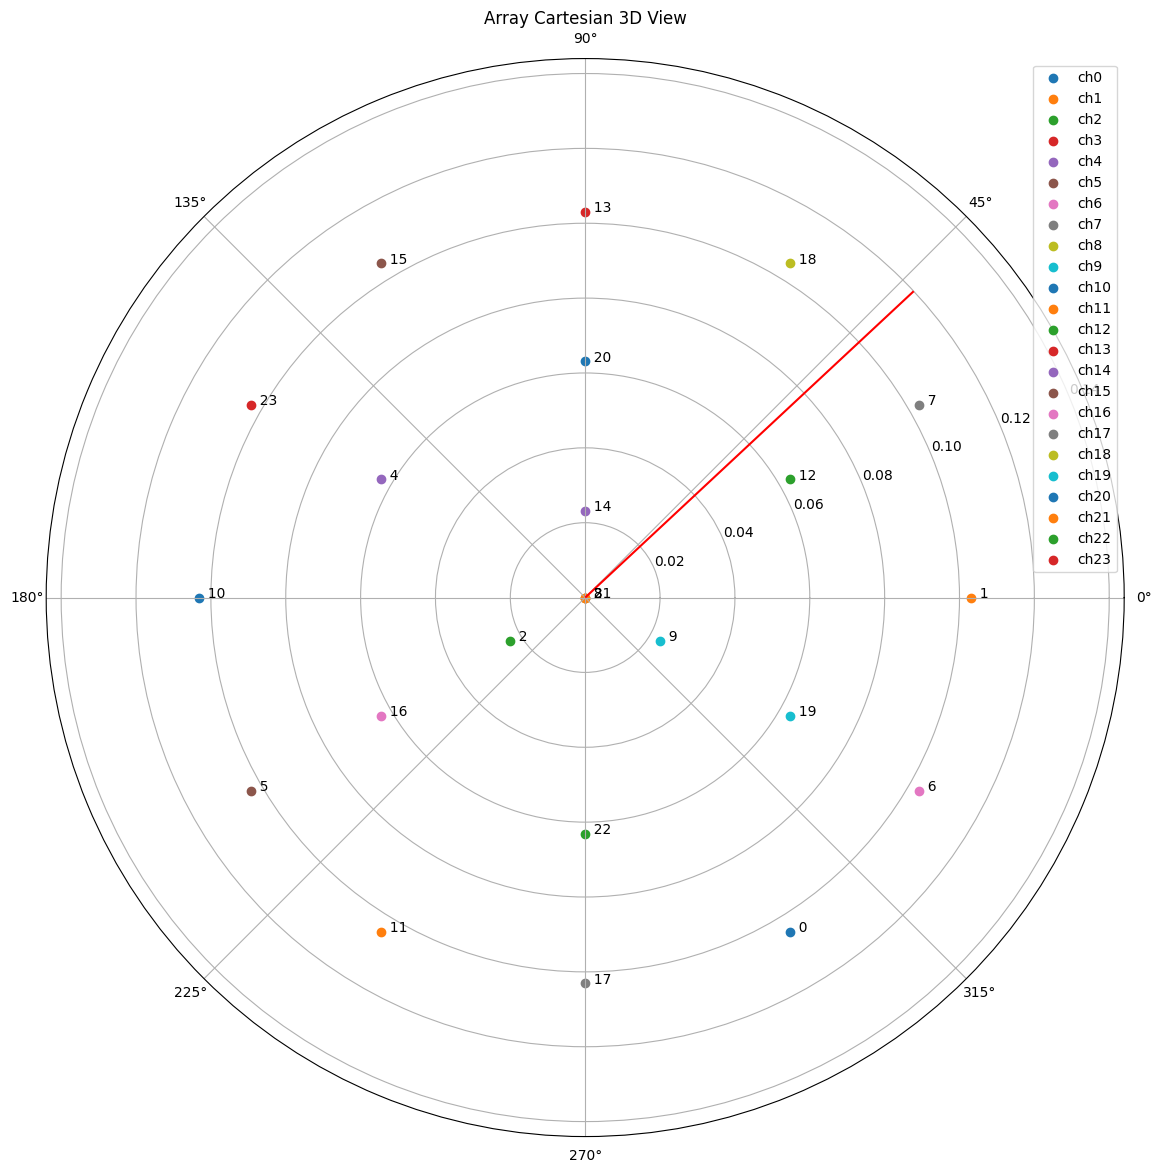

In [67]:
visualizer = Visualizer(AA_Geometry)
visualizer.polar(43)

In [376]:
data = DataExtract("../data/rss45/", 24)

['random_signal_source_info_0.dat', 'random_signal_source_info_1.dat', 'random_signal_source_info_2.dat', 'random_signal_source_info_3.dat', 'random_signal_source_info_4.dat']
['random_signal_source_info_0_tau.bin', 'random_signal_source_info_1_tau.bin', 'random_signal_source_info_2_tau.bin', 'random_signal_source_info_3_tau.bin', 'random_signal_source_info_4_tau.bin']


In [377]:
inputs = data.get_delays()
labels = data.get_angles()
inputs.shape, labels.shape

((500, 24), (500, 1))

In [378]:
channel_id = [1,13,16,2] 

dataset = DataSetPacker(inputs, labels, channel_id)

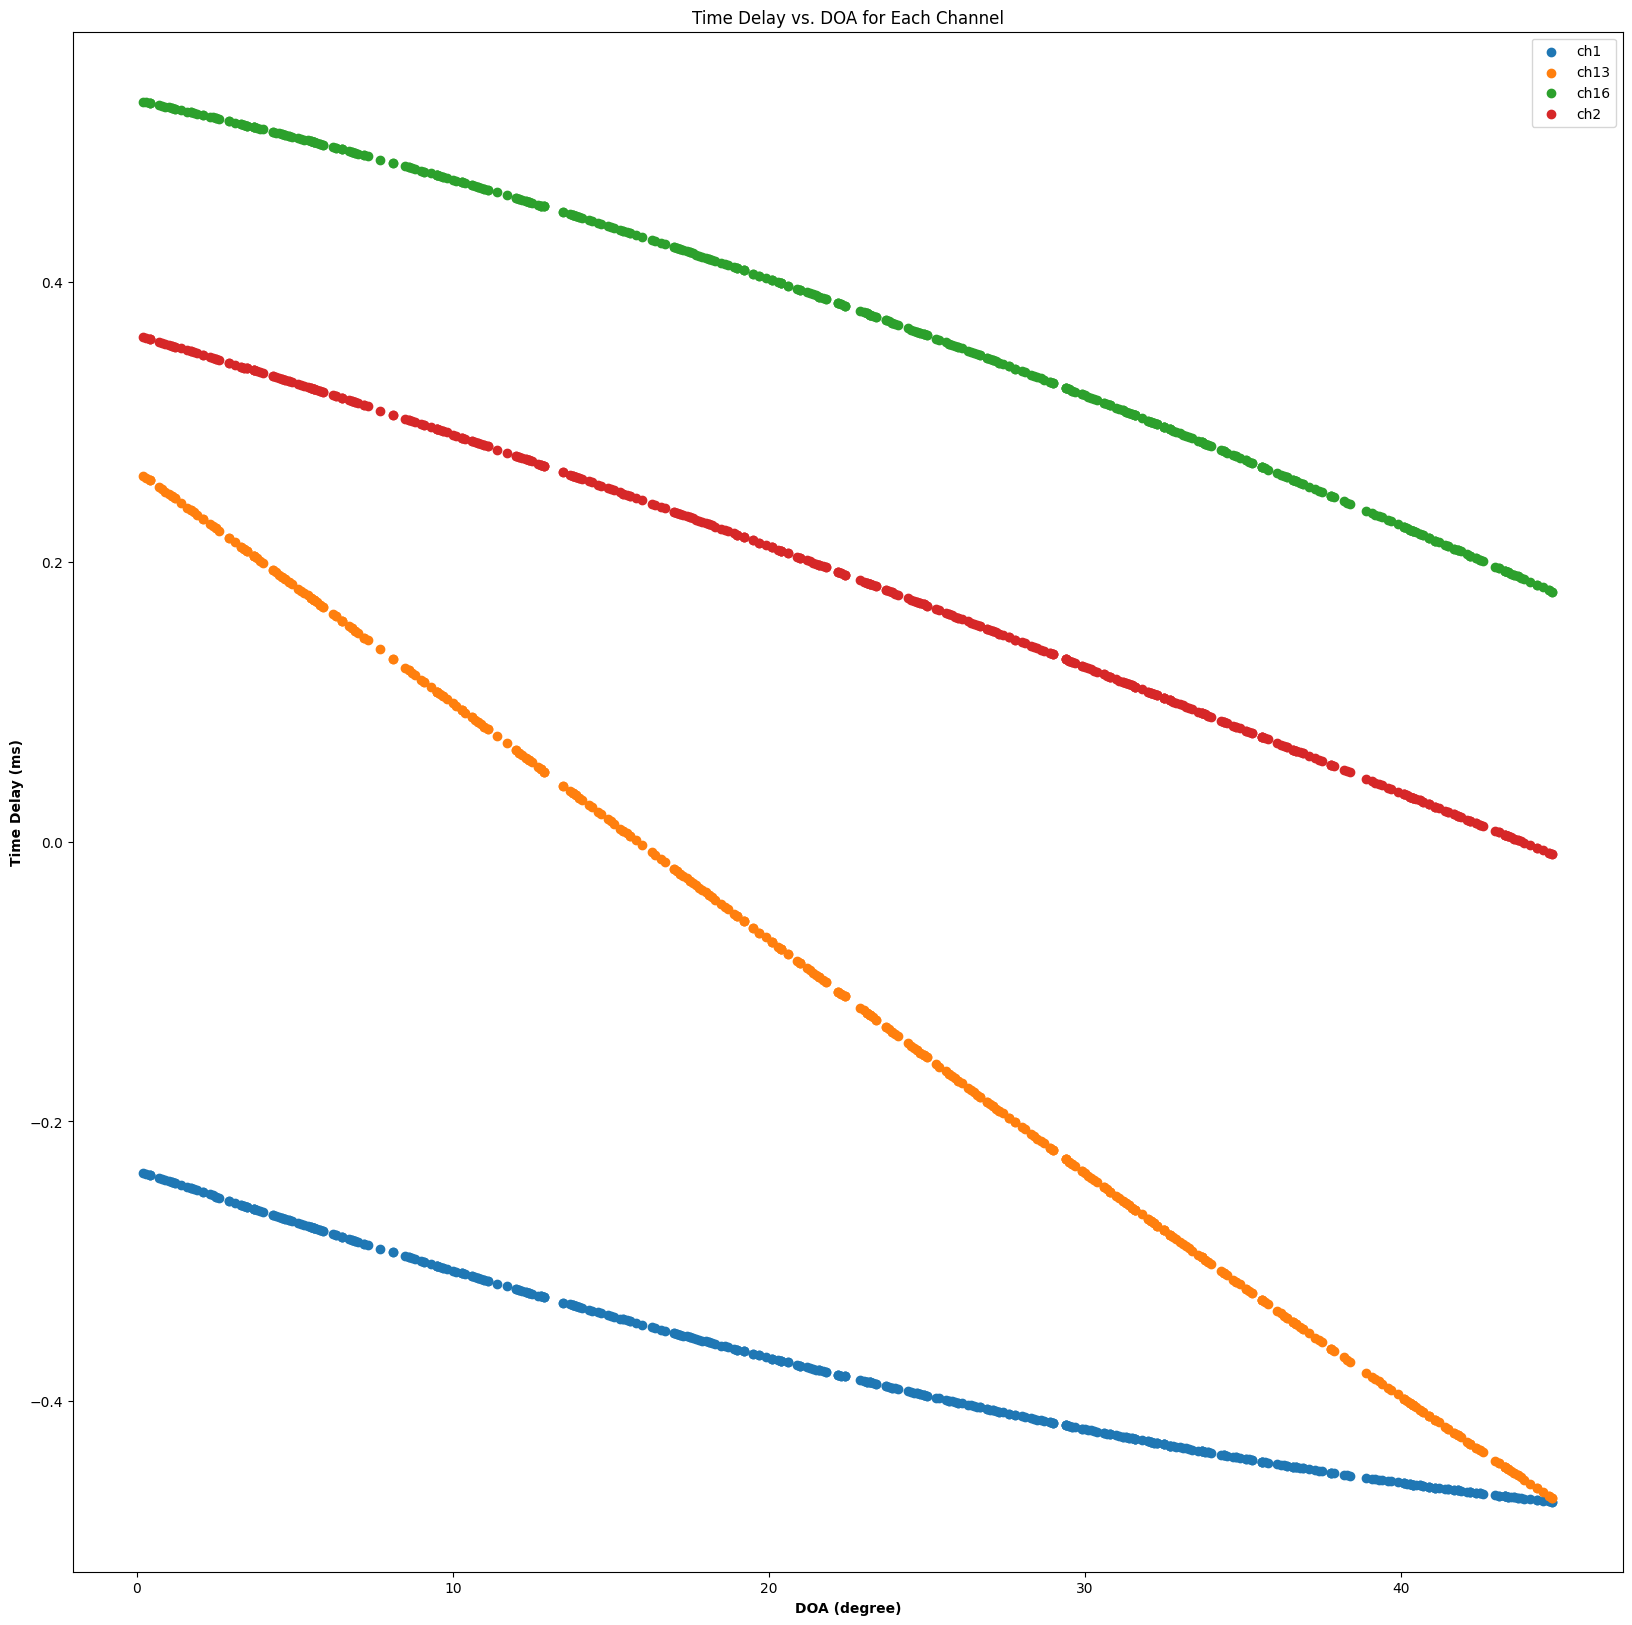

In [379]:
dataset.plot()

In [ ]:
train_dataset, val_dataset, 

# Experiment with 4 Channels

In [359]:
# Train/Test spilt
X_data = data.get_delays()
Y_data = data.get_angles()
indices = np.random.permutation(X_data.shape[0])
train_id, test_id = indices[:int(X_data.shape[0]*0.80)], indices[int(X_data.shape[0]*0.80):]
x_train, y_train, x_test, y_test = X_data[train_id,:], Y_data[train_id], X_data[test_id,:], Y_data[test_id]
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((400, 24), (400, 1), (100, 24), (100, 1))

In [360]:
# Train/Test with 2 channel
channel_id = [1,13,16,2] 
x_train_4 = x_train[:, channel_id]
y_train_4 = y_train
x_test_4 = x_test[:, channel_id]
y_test_4 = y_test

x_train_4.shape

(400, 4)

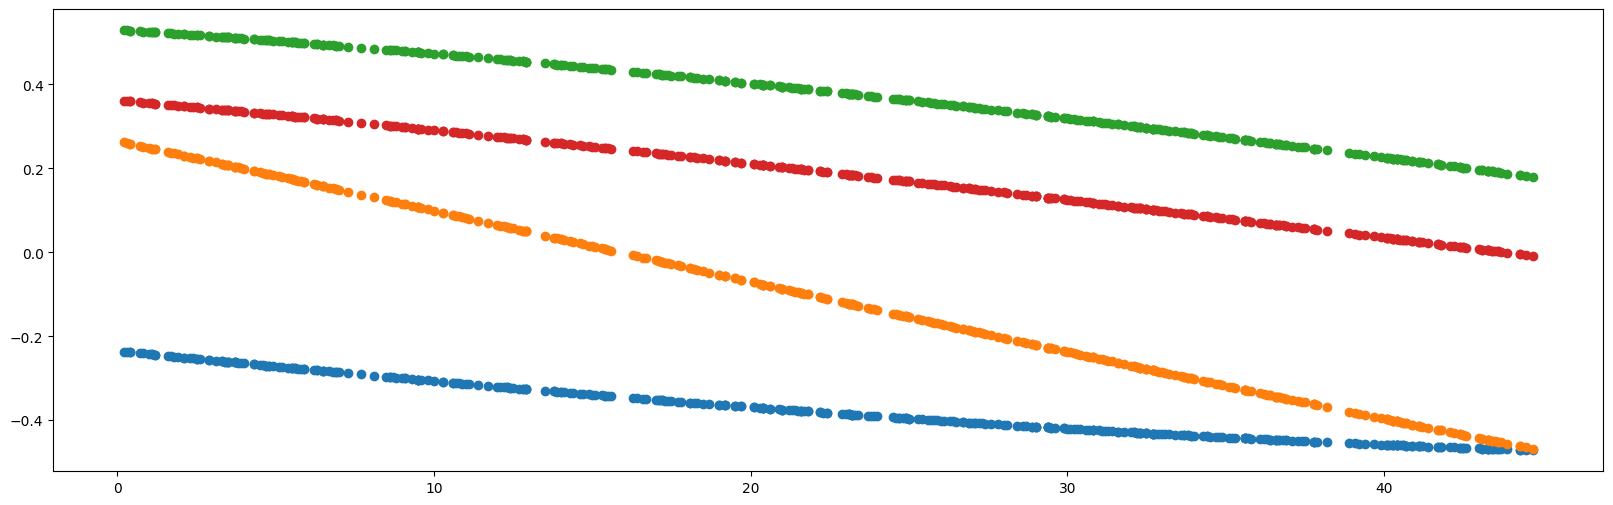

In [361]:
fig = plt.figure(figsize = (20,6))
ax = plt.axes()
for i in range(len(channel_id)):
    ax.scatter(y_train_4, x_train_4[:,i])

In [348]:
model4 = tf.keras.Sequential([
    tf.keras.layers.Input(x_train_4[0].shape),
    #tf.keras.layers.Normalization(),
    tf.keras.layers.Dense(units=16, activation='relu'),
    tf.keras.layers.Dense(units=8, activation='relu'),
    tf.keras.layers.Dense(units=1, activation = 'linear')
])
model4.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16)             │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225 (900.00 B)

 Trainable params: 225 (900.00 B)

 Non-trainable params: 0 (0.00 B)

In [363]:
model4 = MyModel(x_train_4[0].shape)

In [364]:
model4.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [365]:
losses = model4.fit(x_train_4, y_train_4,
                   batch_size=8,
                   epochs=200)

Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 714.2875 - mae: 23.4235   
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step - loss: 648.7050 - mae: 22.0260
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 899us/step - loss: 563.9945 - mae: 20.0824
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step - loss: 480.3215 - mae: 18.1316
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step - loss: 331.6088 - mae: 15.1789
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step - loss: 198.0655 - mae: 11.9345
Epoch 7/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 876us/step - loss: 138.2957 - mae: 10.0788
Epoch 8/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 870us/step - loss: 120.3855 - mae: 9.4298
Epoch 9/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 872us/step - loss: 91.3998 - mae: 8.1893 
Epoch 10/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step - loss: 75.2768 - mae: 7.4063
Epoch 11/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 859us/step - loss: 56.2522 - mae: 6.5286
Epoch 12/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 870us/step - loss: 39.370

In [367]:
np.sqrt(np.mean((model4.predict(x_test_4)-y_test_4)**2))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


np.float32(0.19813873)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


ValueError: x and y must be the same size

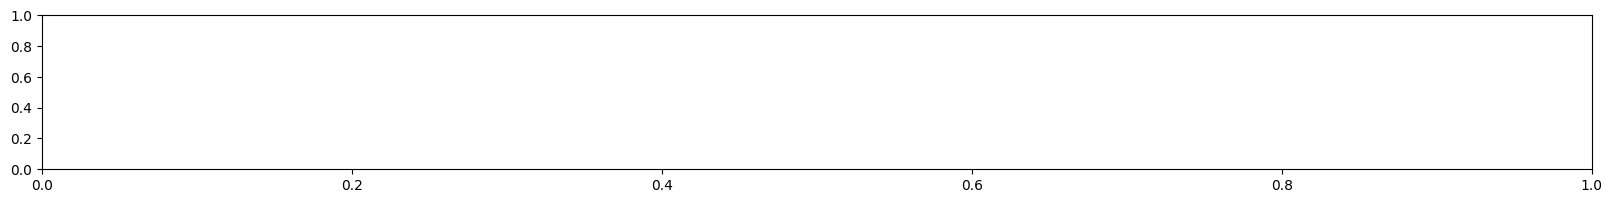

In [366]:
fig = plt.figure(figsize = (20,2))
ax = plt.axes()
#for i in range(len(channel_id)):
ax.scatter(y_test_4, model4.predict(x_test_4).flatten() - y_test_4)
    #ax.scatter(y_test_4, x_test_4[:,i])
    #ax.scatter(model4.predict(x_test_4), x_test_4[:,i])



4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


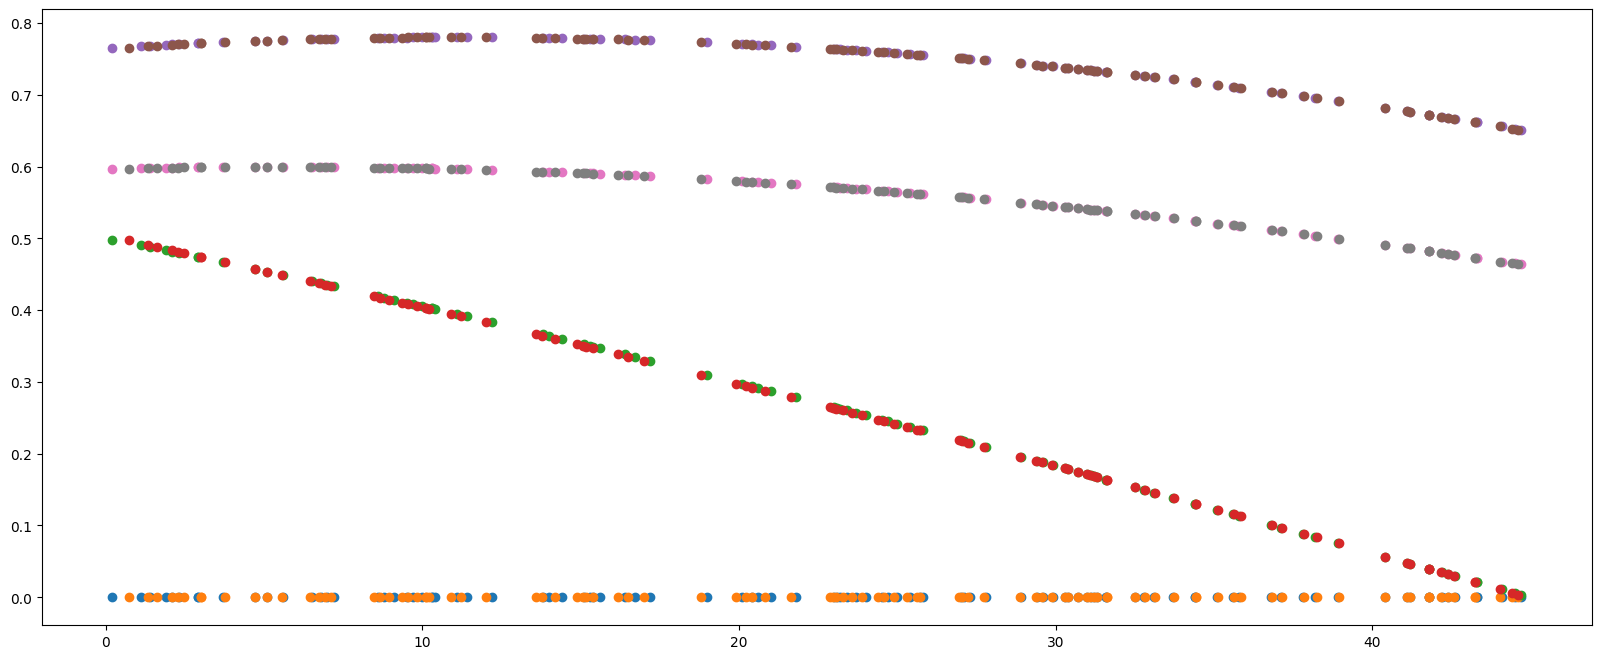

In [37]:
fig = plt.figure(figsize = (20,8))
ax = plt.axes()
for i in range(len(channel_id)):
    ax.scatter(y_test_4, x_test_4[:,i])
    ax.scatter(model4.predict(x_test_4), x_test_4[:,i])



In [424]:
model4.predict(x_test_4).flatten() - y_test_4

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


array([-0.07916908,  0.04246902,  0.04635391,  0.01985512, -0.06350784,
       -0.06386681,  0.04087372,  0.03911171,  0.00452957, -0.08978806,
        0.05349555, -0.06362076, -0.17527695, -0.03437424, -0.05744705,
        0.12552605,  0.04577255, -0.06071625,  0.03829651,  0.01828232,
       -0.11944809,  0.0139801 ,  0.1195652 ,  0.02531815, -0.03322563,
        0.0643856 , -0.03207703,  0.01193848,  0.00452957,  0.02443466,
        0.00123444, -0.03701553,  0.0446785 ,  0.03672028,  0.13156319,
        0.0226429 , -0.07330589, -0.06103897, -0.04989204, -0.0355114 ,
       -0.06854248,  0.04634781, -0.17062912, -0.07083549, -0.09330673,
        0.01498184, -0.18473282, -0.02629395, -0.02092056, -0.08280888,
        0.0314827 , -0.12741623,  0.04580765, -0.02284317,  0.04632187,
       -0.06103897, -0.06559906, -0.02081223,  0.04577255,  0.04509277,
       -0.01222014, -0.00945511, -0.05910606, -0.04003906, -0.17527695,
        0.04460106, -0.07002258, -0.09688644, -0.05158844,  0.04

# Test

In [442]:
# Train/Test with 2 channel
channel_id = [1,7,18,13] 
x_train_4 = x_train[:, channel_id]
y_train_4 = y_train
x_test_4 = x_test[:, channel_id]
y_test_4 = y_test

x_train_4.shape

(400, 4)

In [443]:
x_train_4 = x_train_4 - x_train_4[:,[0]]
x_test_4 = x_test_4 - x_test_4[:,[0]]
x_train_4[:10]

array([[ 0.        , -0.45757538, -0.18659484,  0.9489191 ],
       [ 0.        ,  0.29947054,  1.2322276 ,  2.7941568 ],
       [ 0.        ,  0.11387397,  0.89977866,  2.3891208 ],
       [ 0.        , -0.4989197 , -0.26904744,  0.83286417],
       [ 0.        , -0.5271199 , -0.3256157 ,  0.7526945 ],
       [ 0.        ,  0.11116529,  0.8948527 ,  2.3829815 ],
       [ 0.        , -0.5804088 , -0.43325925,  0.5988972 ],
       [ 0.        , -0.5398746 , -0.35129052,  0.7161599 ],
       [ 0.        , -0.04623609,  0.6049841 ,  2.0151    ],
       [ 0.        , -0.26223192,  0.19562808,  1.4746412 ]],
      dtype=float32)

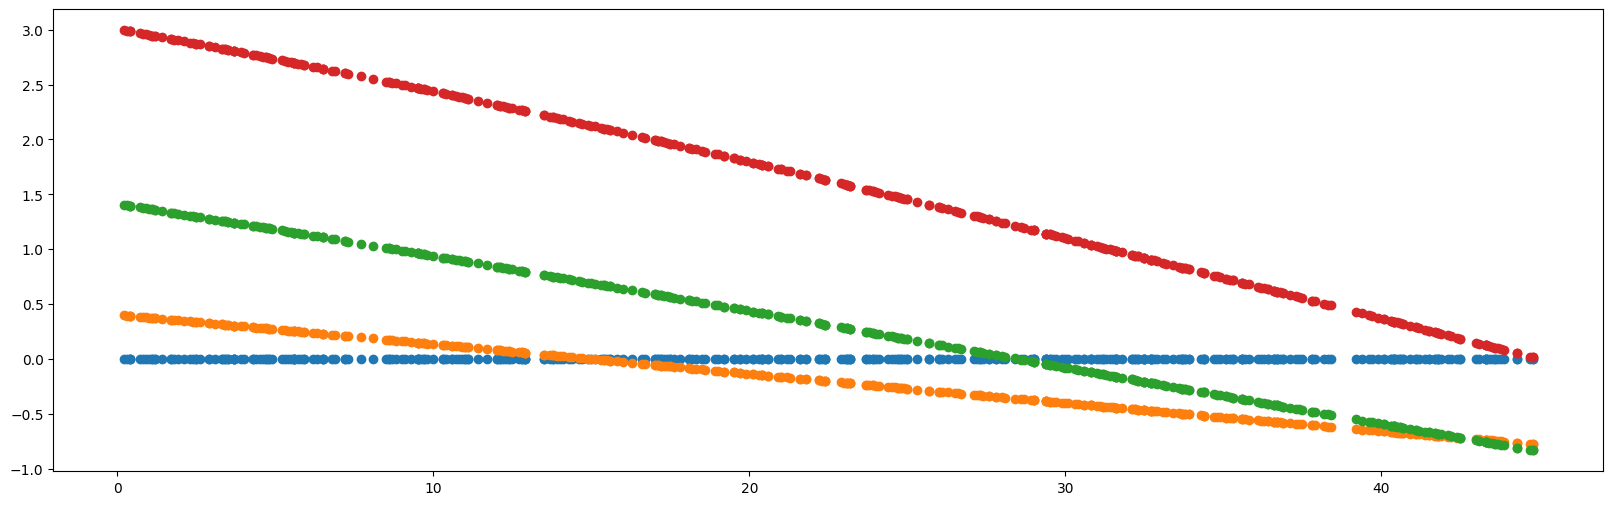

In [444]:
fig = plt.figure(figsize = (20,6))
ax = plt.axes()
for i in range(len(channel_id)):
    ax.scatter(y_train_4, x_train_4[:,i])

In [445]:
model4 = tf.keras.Sequential([
    tf.keras.layers.Input(x_train_4[0].shape),
    #tf.keras.layers.Normalization(),
    tf.keras.layers.Dense(units=16, activation='relu'),
    tf.keras.layers.Dense(units=8, activation='relu'),
    tf.keras.layers.Dense(units=1, activation = 'linear')
])
model4.summary()

Model: "sequential_71"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_221 (Dense)               │ (None, 16)             │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_222 (Dense)               │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_223 (Dense)               │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225 (900.00 B)

 Trainable params: 225 (900.00 B)

 Non-trainable params: 0 (0.00 B)

In [446]:
model4.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [447]:
losses = model4.fit(x_train_4, y_train_4,
                   batch_size=8,
                   epochs=200)

Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 694.0431 - mae: 22.8801   
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 608.7482 - mae: 20.5230 
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step - loss: 601.1650 - mae: 20.2160
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step - loss: 473.8510 - mae: 17.8271
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step - loss: 338.5877 - mae: 15.1838
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step - loss: 245.4361 - mae: 13.2992
Epoch 7/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 171.0070 - mae: 11.1756 
Epoch 8/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step - loss: 95.3570 - mae: 8.2710
Epoch 9/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step - loss: 53.1730 - mae: 6.0886
Epoch 10/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step - loss: 20.3090 - mae: 3.5923
Epoch 11/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step - loss: 6.2172 - mae: 1.7740
Epoch 12/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step - loss: 2.3411 - ma

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


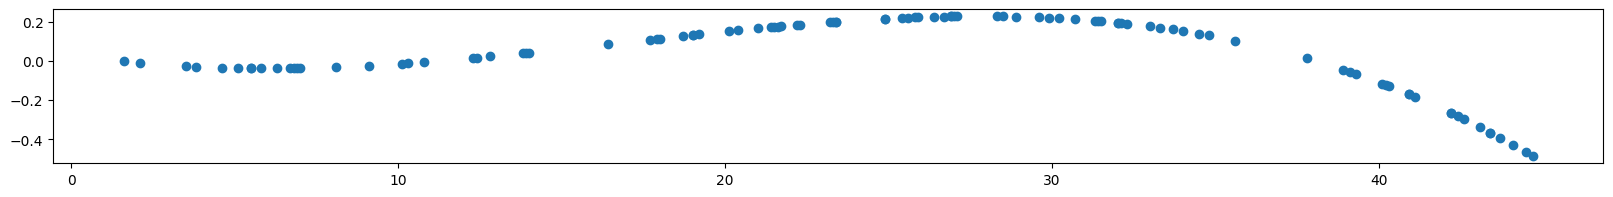

In [448]:
fig = plt.figure(figsize = (20,2))
ax = plt.axes()
#for i in range(len(channel_id)):
ax.scatter(y_test_4, model4.predict(x_test_4).flatten() - y_test_4)
    #ax.scatter(y_test_4, x_test_4[:,i])
    #ax.scatter(model4.predict(x_test_4), x_test_4[:,i])



4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


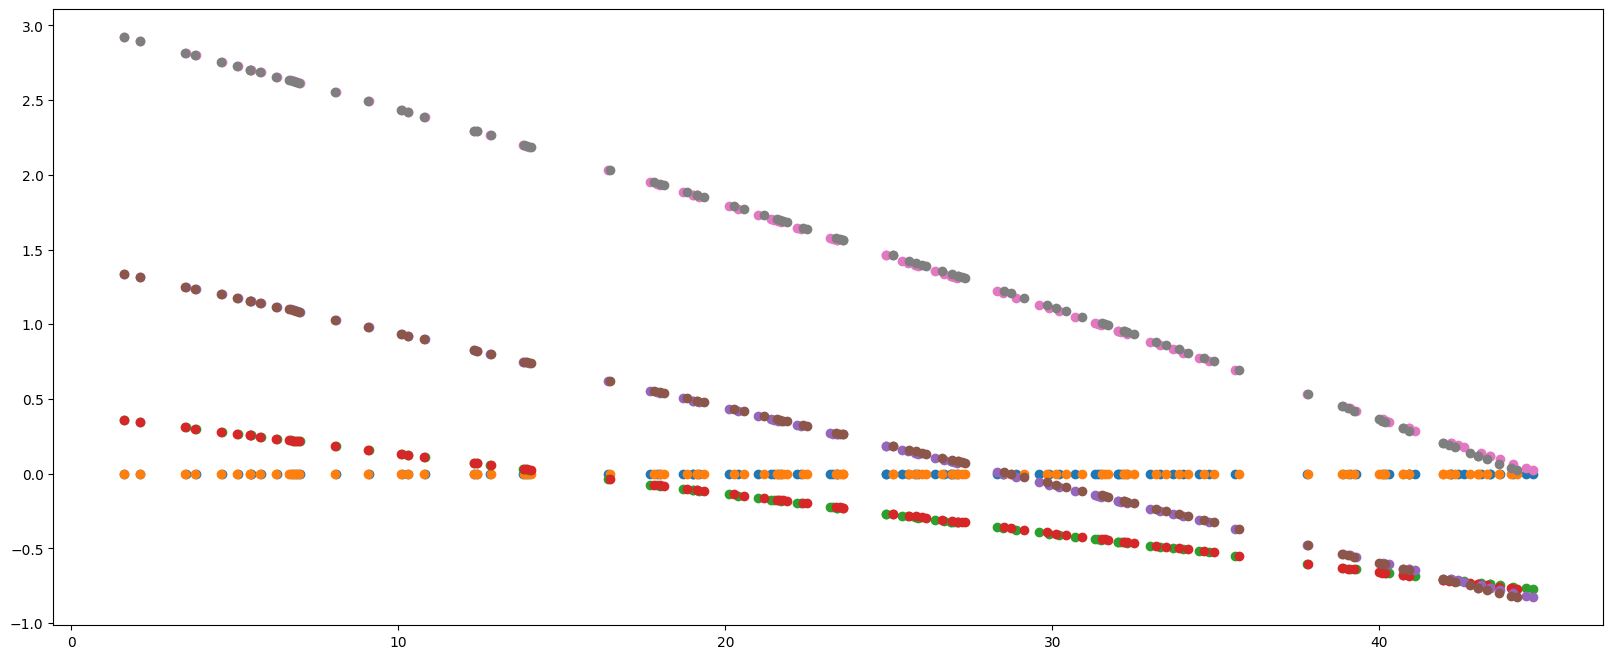

In [449]:
fig = plt.figure(figsize = (20,8))
ax = plt.axes()
for i in range(len(channel_id)):
    ax.scatter(y_test_4, x_test_4[:,i])
    ax.scatter(model4.predict(x_test_4), x_test_4[:,i])



In [424]:
model4.predict(x_test_4).flatten() - y_test_4

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


array([-0.07916908,  0.04246902,  0.04635391,  0.01985512, -0.06350784,
       -0.06386681,  0.04087372,  0.03911171,  0.00452957, -0.08978806,
        0.05349555, -0.06362076, -0.17527695, -0.03437424, -0.05744705,
        0.12552605,  0.04577255, -0.06071625,  0.03829651,  0.01828232,
       -0.11944809,  0.0139801 ,  0.1195652 ,  0.02531815, -0.03322563,
        0.0643856 , -0.03207703,  0.01193848,  0.00452957,  0.02443466,
        0.00123444, -0.03701553,  0.0446785 ,  0.03672028,  0.13156319,
        0.0226429 , -0.07330589, -0.06103897, -0.04989204, -0.0355114 ,
       -0.06854248,  0.04634781, -0.17062912, -0.07083549, -0.09330673,
        0.01498184, -0.18473282, -0.02629395, -0.02092056, -0.08280888,
        0.0314827 , -0.12741623,  0.04580765, -0.02284317,  0.04632187,
       -0.06103897, -0.06559906, -0.02081223,  0.04577255,  0.04509277,
       -0.01222014, -0.00945511, -0.05910606, -0.04003906, -0.17527695,
        0.04460106, -0.07002258, -0.09688644, -0.05158844,  0.04